## Using Aruco Marker to locate object (in 2D Plane)
reference:  
[basic example](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html)

### 1. First import libraries

In [3]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

### 2. Create Aruco Marker
Can use follow website to generate aruco marker with specific size you want:  
[Online Aruco marker generator](http://chev.me/arucogen/)

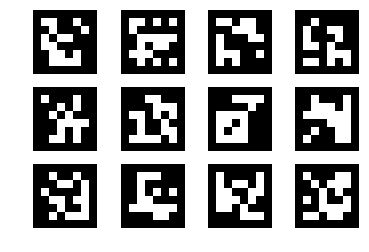

In [10]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx=4
ny=3
for i in range(1,nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i+2, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("markers.pdf")
plt.show()

### 3. Print, Cut, Stick  and take a picture

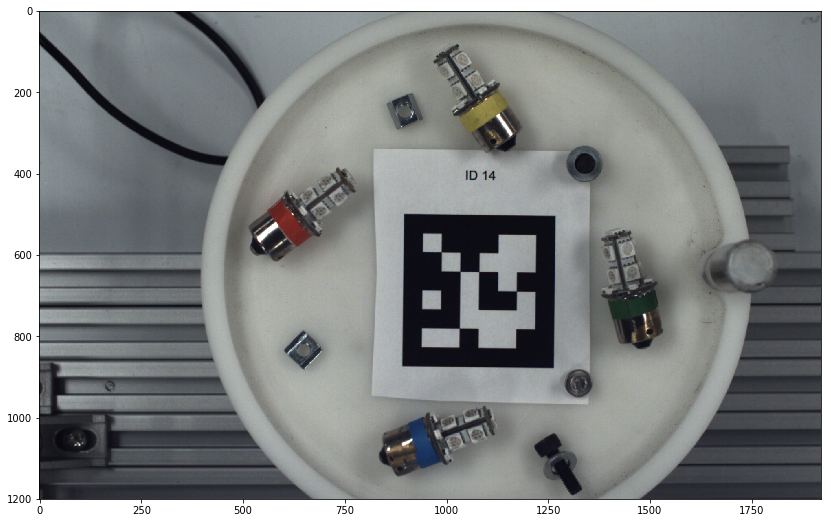

In [4]:
#frame = cv2.imread("_data/aruco_photo.jpg")
frame = cv2.imread("_data/aruco_calib.jpg")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # depend on source
plt.figure(figsize = (14,11))
plt.imshow(frame)
plt.show()

### 4. Post processing

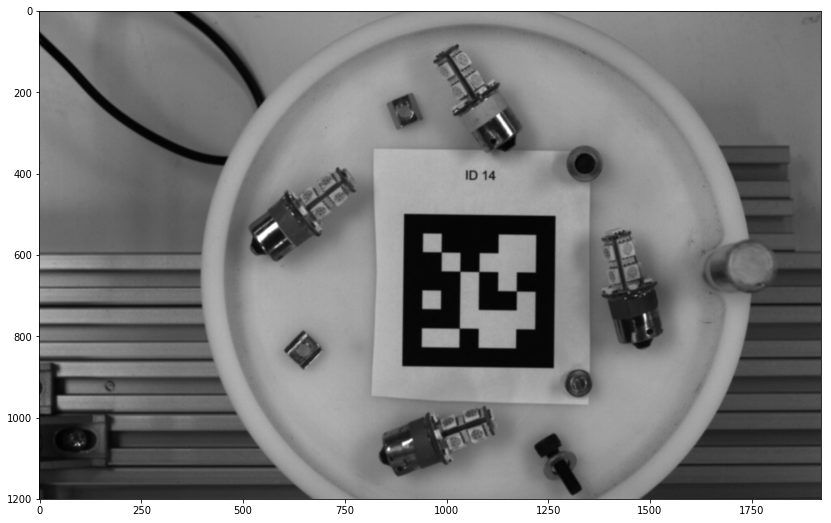

In [5]:
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (14,11))
plt.imshow(gray,cmap = 'gray', interpolation = 'bicubic')
plt.show()

### 5. Detect Aruco Marker in the picture

In [6]:
%time
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

Wall time: 0 ns


### 6. Show detecting result

[[  897.   500.]
 [ 1268.   506.]
 [ 1263.   878.]
 [  892.   873.]]


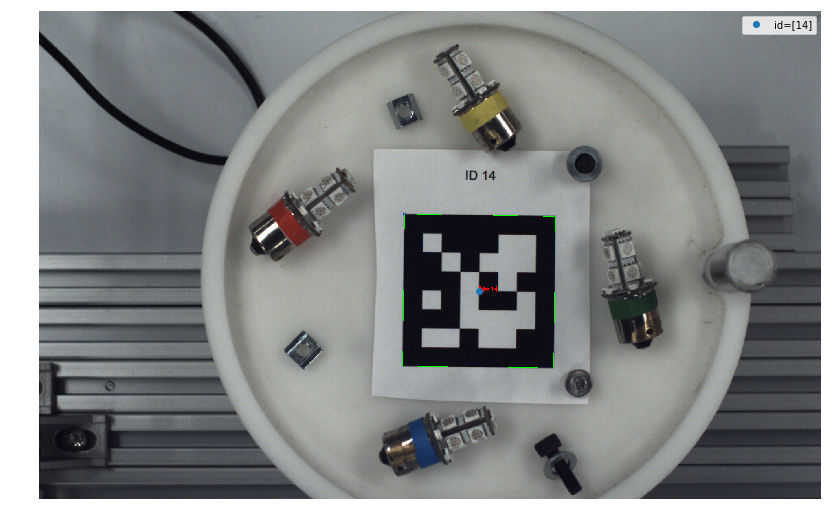

In [7]:
plt.figure(figsize = (14,11))
plt.imshow(frame_markers, aspect='equal')
for i in range(len(ids)):
    c = corners[i][0]
    print c[0:]
    plt.plot([c[:,0].mean()], [c[:,1].mean()], "o", label= "id={0}".format(ids[i]))
plt.legend()
plt.axis("off")
plt.savefig("detect_marker.png") # note: the pixel position of corners are different from origin.
plt.show()

In [8]:
# Compute mean  (optional)
def quad_area(data):
    l = data.shape[0]//2
    corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
    c1 = corners[:, :, 0]
    c2 = corners[:, :, 1]
    c3 = corners[:, :, 2]
    c4 = corners[:, :, 3]
    e1 = c2-c1
    e2 = c3-c2
    e3 = c4-c3
    e4 = c1-c4
    a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
    return a

corners2 = np.array([c[0] for c in corners])

data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                   index = pd.MultiIndex.from_product(
                           [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]],
                       names = ["marker", ""] ))

data = data.unstack().swaplevel(0, 1, axis = 1).stack()
data["m1"] = data[["c1", "c2"]].mean(axis = 1)
data["m2"] = data[["c2", "c3"]].mean(axis = 1)
data["m3"] = data[["c3", "c4"]].mean(axis = 1)
data["m4"] = data[["c4", "c1"]].mean(axis = 1)
data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
data

c1      c2      c3     c4      m1      m2      m3     m4        o
marker                                                                        
14     x  897.0  1268.0  1263.0  892.0  1082.5  1265.5  1077.5  894.5  1080.00
       y  500.0   506.0   878.0  873.0   503.0   692.0   875.5  686.5   689.25

### 7. Use OpenCV `getPerspectiveTransform` to get transfer martix that map from pixel to 500 x 500 unit 0.1 mm
The marker I printed is a 50mmx50mm aruco marker

[[  1.33502728e+00   1.78958081e-02  -1.20646738e+03]
 [ -2.15319077e-02   1.33138963e+00  -6.46380692e+02]
 [ -7.17470623e-06  -1.92648245e-07   1.00000000e+00]]


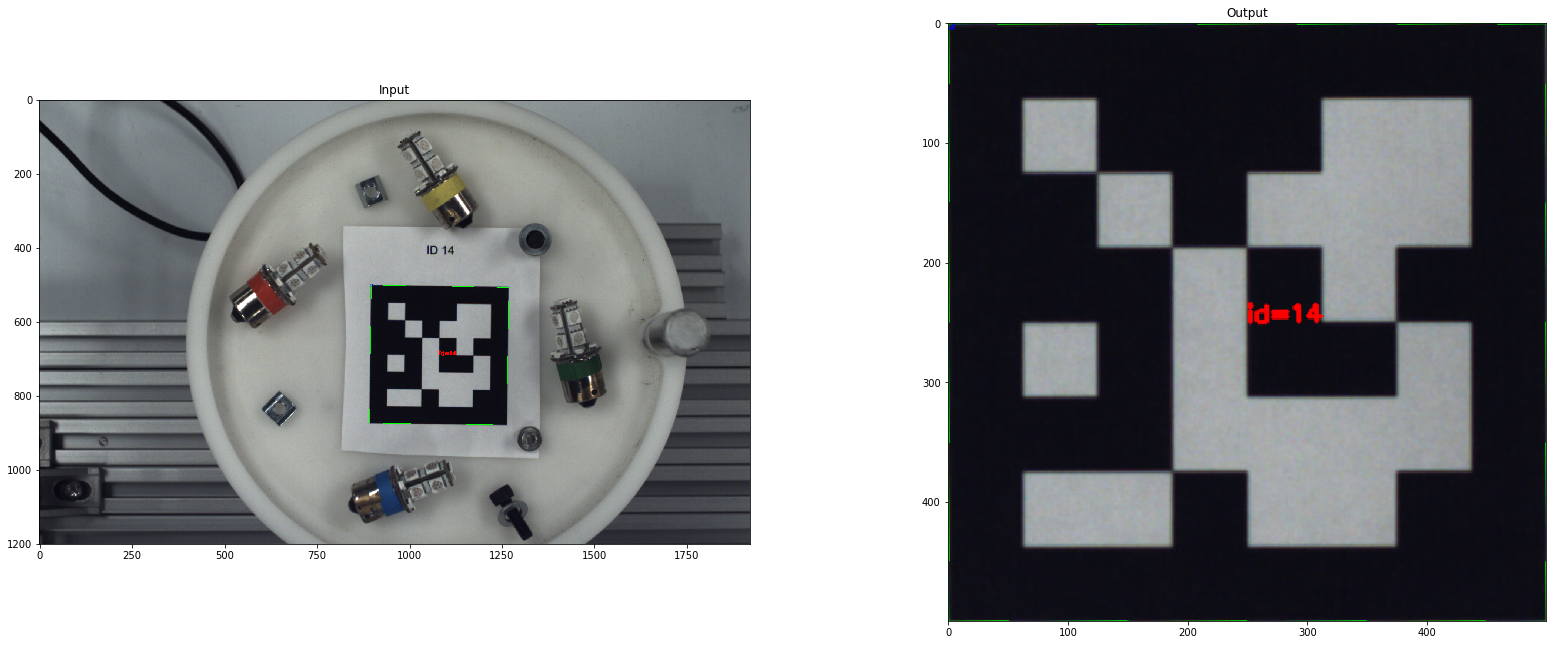

In [11]:
rows, cols, ch = frame_markers.shape
corner1 =  corners[0][0]
#print corner1
#print corner1[0]
pts1 = np.float32(corner1)
pts2 = np.float32([ [0,0], [500, 0], [500, 500], [0, 500] ])
#print pts2

M = cv2.getPerspectiveTransform(pts1, pts2)
frame_transform = cv2.warpPerspective(frame_markers, M, (500,500))
print M
plt.figure(figsize = (28,11))
plt.subplot(121),plt.imshow(frame_markers),plt.title('Input')
plt.subplot(122),plt.imshow(frame_transform),plt.title('Output')
plt.show()

### 8. Save or Load 2D transformation Matrix  

In [26]:
# SAVE
# !! Note beaware not to overwrite Saved calibration resutl  
import pickle as pkl
pkl.dump(M, open("_data/aruco_calib.pkl", "w"))

In [27]:
# Load
import pickle as pkl
M = pkl.load(open("_data/aruco_calib.pkl"))
print M

[[  1.33502728e+00   1.78958081e-02  -1.20646738e+03]
 [ -2.15319077e-02   1.33138963e+00  -6.46380692e+02]
 [ -7.17470623e-06  -1.92648245e-07   1.00000000e+00]]


### 9. Now testing the matrix with a point in pixel.

In [13]:
# Create a point position in pixel.
cnt_point =  np.array([[762, 742, 1]])
print cnt_point
cnt_point.shape
# Get its position in 2D Cartesian Space
M.dot(cnt_point.transpose())/10 # because 1 pixel to 0.1 mm, divede by 10
# Note: first value of array is y position of Robot PCS (Cartesian Space), and Second value is x position

[[762 742   1]]


array([[-17.58978974],
       [ 32.5103097 ],
       [  0.09943899]])

#### Option: Create ChArUco Boards

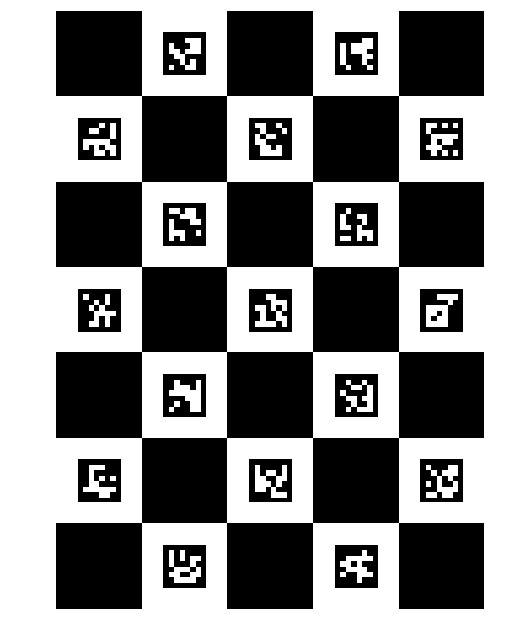

In [14]:
## Refence: https://github.com/kyle-elsalhi/opencv-examples/blob/master/GenerateArucoMarker/GenChArucoboard.py
# ChAruco board variables
CHARUCOBOARD_ROWCOUNT = 7
CHARUCOBOARD_COLCOUNT = 5 
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure(figsize=(8.5, 11))

# Create constants to be passed into OpenCV and Aruco methods
char_board = aruco.CharucoBoard_create(
        squaresX=CHARUCOBOARD_COLCOUNT,
        squaresY=CHARUCOBOARD_ROWCOUNT,
        squareLength=0.04,
        markerLength=0.02,
        dictionary=ARUCO_DICT)

img = char_board.draw(outSize=(850, 1100))

plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
plt.axis("off")

plt.savefig("ChAruco_Board.pdf")
plt.show()